# SGR Stress Relaxation: Aging in Soft Glassy Materials

> **What is SGR?** The Soft Glassy Rheology (SGR) model is a **statistical mechanics framework** for materials with disordered, metastable microstructures—foams, emulsions, pastes, colloidal gels. It treats the material as mesoscopic "elements" trapped in energy wells of depth $E$, with an effective **noise temperature** $x$ providing thermal-like kicks that enable rearrangements. This trap model produces a genuine **glass transition** at $x=1$, separating solid-like and fluid-like phases.

> **Handbook:** [SGR Conventional](../../docs/source/models/sgr/sgr_conventional.rst) • [SGR Generic](../../docs/source/models/sgr/sgr_generic.rst)

## Key Physics: Power-Law Relaxation

SGR predicts **power-law stress relaxation** $G(t) \sim t^{1-x}$ for $1 < x < 2$, distinct from Maxwell's exponential decay. This arises from the exponential trap distribution $\rho(E) = e^{-E}$ combined with Arrhenius hopping $\Gamma(E) = \tau_0^{-1} \exp(-E/x)$.

**Phase-dependent behavior:**
- **$x < 1$** (glass): $G(t) \to$ plateau (aging dominates, no equilibration)
- **$1 < x < 2$** (power-law fluid): $G(t) \sim t^{1-x}$ (broad relaxation spectrum)
- **$x \geq 2$** (Newtonian): Exponential $G(t) \sim e^{-t/\tau_0}$ (single Maxwell time)

**Aging signature**: As soft glasses age (increasing waiting time $t_w$), $x(t_w)$ decreases toward the glass transition, reflecting deeper energy traps and slower dynamics. The characteristic timescale $\tau_{\text{eff}} \sim t_w$ grows with sample age.

**Parameters**:
- $x$: Noise temperature — controls relaxation exponent $(1-x)$
- $G_0$: Plateau modulus — sets stress magnitude
- $\tau_0$: Microscopic time — sets time scale

## Learning Objectives

1. Fit SGRConventional to stress relaxation data from aging clays
2. Track $x(t_{\text{wait}})$ evolution during aging
3. Distinguish power-law vs exponential relaxation
4. Compare SGRConventional vs SGRGeneric
5. Perform Bayesian inference for parameter uncertainty

## Prerequisites

- Basic RheoJAX (`basic/01`)
- Bayesian inference (`bayesian/01`)

## Runtime

- **Fast mode** (1 chain): ~2 min
- **Production** (4 chains): ~5 min

## 1. Setup

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os

    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import json
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.sgr import SGRConventional, SGRGeneric

jax, jnp = safe_import_jax()
verify_float64()

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

## 2. Theory: SGR Stress Relaxation

The Soft Glassy Rheology (SGR) model predicts power-law stress relaxation, distinct from the exponential decay of Maxwell-type models:

$$G(t) = G_0 \cdot G_0(x) \cdot \left(1 + \frac{t}{\tau_0}\right)^{x-2}$$

where:
- **x**: Noise temperature (controls phase behavior)
  - x < 1: Deep glass (G(t) → ∞ as t → ∞)
  - x = 2: Marginal plateau
  - x > 2: Decaying modulus (approaching fluid)
- **G₀**: Elastic modulus scale
- **τ₀**: Elementary relaxation time

**Aging Signature:** As soft glassy materials age (rest at constant temperature), structural rearrangements slow down. In SGR, this is reflected by **decreasing x** over waiting time t_wait, indicating deeper energy traps and slower dynamics.

**Contrast with Maxwell:** Standard viscoelastic models predict G(t) ~ exp(-t/τ), which is exponential (straight line on log-linear plot). SGR's power-law decay appears as a straight line on log-log plot with slope (x-2).

## 3. Load Data

In [4]:
aging_times = [600, 1200, 1800, 2400, 3600]
datasets = {}

for t_age in aging_times:
    data_path = os.path.join("..", "data", "relaxation", "clays", f"rel_lapo_{t_age}.csv")
    raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
    t = raw[:, 0]
    G_t = raw[:, 1]
    datasets[t_age] = {"t": t, "G_t": G_t}
    print(f"t_age={t_age:4d}s: {len(t)} points, t=[{t.min():.3f}, {t.max():.1f}] s")

t_age= 600s: 26 points, t=[0.253, 755.7] s
t_age=1200s: 33 points, t=[0.290, 1483.3] s
t_age=1800s: 27 points, t=[0.350, 1731.0] s
t_age=2400s: 30 points, t=[0.244, 2043.9] s
t_age=3600s: 34 points, t=[0.286, 3152.7] s


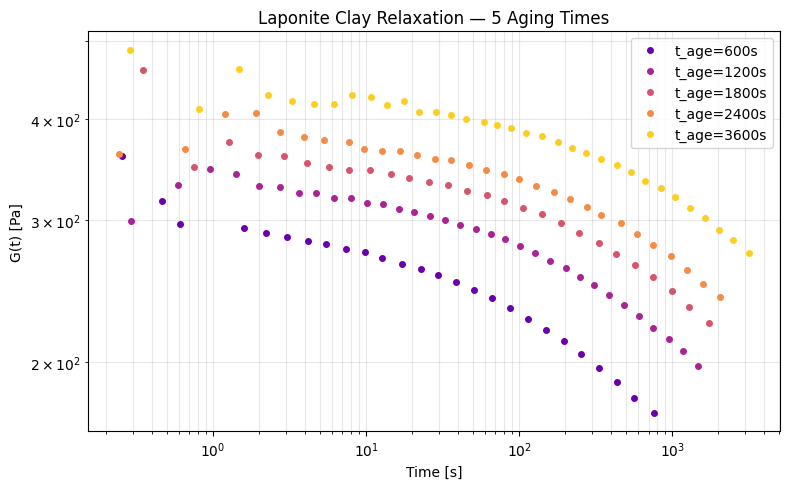

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(aging_times)))

for i, t_age in enumerate(aging_times):
    d = datasets[t_age]
    ax.loglog(d["t"], d["G_t"], "o", color=colors[i], markersize=4, label=f"t_age={t_age}s")

ax.set_xlabel("Time [s]")
ax.set_ylabel("G(t) [Pa]")
ax.set_title("Laponite Clay Relaxation — 5 Aging Times")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Single Aging Time (3600 s)

In [6]:
model = SGRConventional()

d = datasets[3600]
t0_fit = time.time()
model.fit(d["t"], d["G_t"], test_mode="relaxation", method='scipy')
t_nlsq = time.time() - t0_fit

# Compute fit quality
G_pred_fit = model.predict(d["t"])
metrics = compute_fit_quality(d["G_t"], G_pred_fit)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} Pa")
print("\nFitted parameters:")
for name in ["x", "G0", "tau0"]:
    val = model.parameters.get_value(name)
    print(f"  {name:5s} = {val:.4g}")
print(f"Phase regime: {model.get_phase_regime()}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.296830s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=0.0133 | elapsed=1.297s | final_gradient_norm=1.4075


NLSQ fit time: 1.70 s
R²: 0.937040
RMSE: 12.73 Pa

Fitted parameters:
  x     = 1.887
  G0    = 751.6
  tau0  = 73.28
Phase regime: power-law


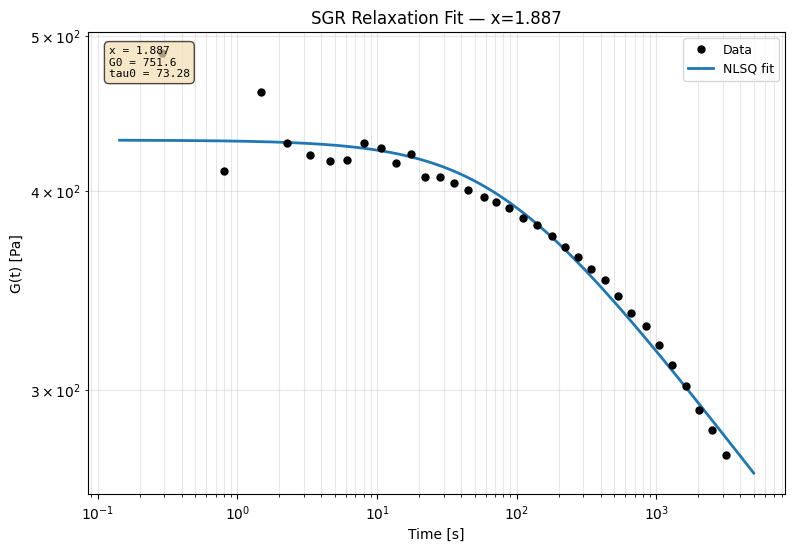

In [7]:
# Plot NLSQ fit with uncertainty band
param_names = ["x", "G0", "tau0"]
x_fit = model.parameters.get_value("x")
fig, ax = plot_nlsq_fit(
    d["t"], d["G_t"], model, test_mode="relaxation",
    param_names=param_names,
    xlabel="Time [s]", ylabel="G(t) [Pa]",
    title=f"SGR Relaxation Fit — x={x_fit:.3f}",
)
display(fig)
plt.close(fig)

### 4.2 Aging Time Sweep

In [8]:
fit_results = {}

for t_age in aging_times:
    m = SGRConventional()
    d = datasets[t_age]
    m.fit(d["t"], d["G_t"], test_mode="relaxation", method='scipy')
    
    # Compute fit quality
    G_pred = m.predict(d["t"])
    metrics = compute_fit_quality(d["G_t"], G_pred)
    
    fit_results[t_age] = {
        "x": float(m.parameters.get_value("x")),
        "G0": float(m.parameters.get_value("G0")),
        "tau0": float(m.parameters.get_value("tau0")),
        "R2": float(metrics["R2"]),
        "regime": m.get_phase_regime(),
    }

print(f"{'t_age':>6s}  {'x':>6s}  {'G0':>10s}  {'τ₀':>10s}  {'R²':>8s}  {'Regime'}")
print("-" * 60)
for t_age in aging_times:
    r = fit_results[t_age]
    print(
        f"{t_age:6d}  {r['x']:6.3f}  {r['G0']:10.2f}  {r['tau0']:10.2e}  {r['R2']:8.5f}  {r['regime']}"
    )

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.427029s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=11 | final_cost=0.5473 | elapsed=0.427s | final_gradient_norm=4.6492e+05


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.420081s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=14 | final_cost=0.0085 | elapsed=0.420s | final_gradient_norm=0.2410


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.449172s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=0.0259 | elapsed=0.449s | final_gradient_norm=3.8696


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.424710s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=0.0081 | elapsed=0.425s | final_gradient_norm=0.5250


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.284262s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=0.0133 | elapsed=0.284s | final_gradient_norm=1.4075


 t_age       x          G0          τ₀        R²  Regime
------------------------------------------------------------
   600   1.839     4737.33    5.09e-06  -0.57033  power-law
  1200   1.862      567.01    4.66e+01   0.96985  power-law
  1800   1.890      642.12    2.62e+01   0.85241  power-law
  2400   1.874      661.06    6.59e+01   0.95981  power-law
  3600   1.887      751.55    7.33e+01   0.93704  power-law


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.298439s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=11 | final_cost=0.5473 | elapsed=0.298s | final_gradient_norm=4.6492e+05


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.269342s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=14 | final_cost=0.0085 | elapsed=0.269s | final_gradient_norm=0.2410


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.276205s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=0.0259 | elapsed=0.276s | final_gradient_norm=3.8696


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.288525s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=0.0081 | elapsed=0.289s | final_gradient_norm=0.5250


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.407598s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=0.0133 | elapsed=0.408s | final_gradient_norm=1.4075


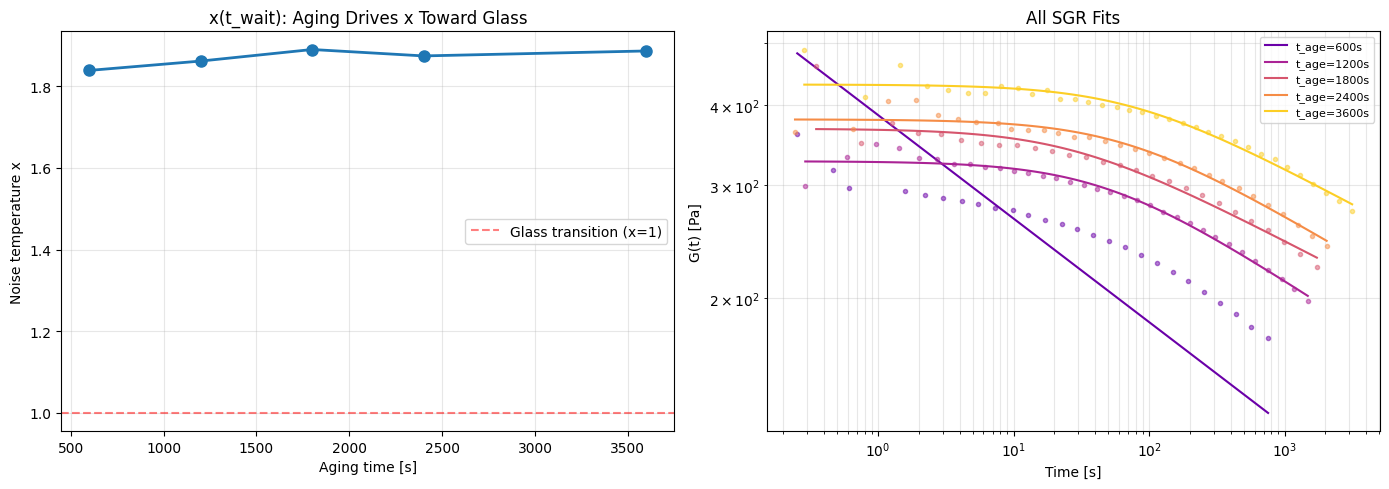

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ages = list(fit_results.keys())
x_vals = [fit_results[a]["x"] for a in ages]

ax1.plot(ages, x_vals, "o-", markersize=8, lw=2)
ax1.axhline(1.0, color="red", linestyle="--", alpha=0.5, label="Glass transition (x=1)")
ax1.set_xlabel("Aging time [s]")
ax1.set_ylabel("Noise temperature x")
ax1.set_title("x(t_wait): Aging Drives x Toward Glass")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Overlay all fits
for i, t_age in enumerate(aging_times):
    d = datasets[t_age]
    ax2.loglog(d["t"], d["G_t"], "o", color=colors[i], markersize=3, alpha=0.5)
    m = SGRConventional()
    m.fit(d["t"], d["G_t"], test_mode="relaxation", method='scipy')
    t_f = np.logspace(np.log10(d["t"].min()), np.log10(d["t"].max()), 100)
    ax2.loglog(t_f, m.predict(t_f), "-", color=colors[i], lw=1.5, label=f"t_age={t_age}s")

ax2.set_xlabel("Time [s]")
ax2.set_ylabel("G(t) [Pa]")
ax2.set_title("All SGR Fits")
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

### 4.3 SGRGeneric Comparison

In [10]:
d = datasets[3600]
model_gen = SGRGeneric()
model_gen.fit(d["t"], d["G_t"], test_mode="relaxation", method='scipy')

# Compute fit quality for both models
G_conv_fit = model.predict(d["t"])
G_gen_fit = model_gen.predict(d["t"])
metrics_conv = compute_fit_quality(d["G_t"], G_conv_fit)
metrics_gen = compute_fit_quality(d["G_t"], G_gen_fit)

print("SGRConventional vs SGRGeneric (t_age=3600s):")
print(
    f"  Conventional: x={model.parameters.get_value('x'):.4f}, R²={metrics_conv['R2']:.6f}"
)
print(
    f"  Generic:      x={model_gen.parameters.get_value('x'):.4f}, R²={metrics_gen['R2']:.6f}"
)

state = np.array([100.0, 0.5])
consistency = model_gen.verify_thermodynamic_consistency(state)
print(
    f"\nThermodynamic consistency: {consistency.get('thermodynamically_consistent', 'N/A')}"
)
for key, val in consistency.items():
    if key != "thermodynamically_consistent":
        print(f"  {key}: {val}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.348114s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=0.0133 | elapsed=0.348s | final_gradient_norm=1.4075


SGRConventional vs SGRGeneric (t_age=3600s):
  Conventional: x=1.8865, R²=0.937040
  Generic:      x=1.8865, R²=0.937040

Thermodynamic consistency: True
  poisson_antisymmetric: True
  poisson_antisymmetry_error: 0.0
  friction_symmetric: True
  friction_symmetry_error: 0.0
  friction_positive_semidefinite: True
  friction_min_eigenvalue: 0.0020078258082430835
  entropy_production_nonnegative: True
  entropy_production: 4.710980558516504


## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

In [11]:
initial_values = {name: model.parameters.get_value(name) for name in ["x", "G0", "tau0"]}
print("Warm-start values:", initial_values)

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    d["t"],
    d["G_t"],
    test_mode="relaxation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values: {'x': 1.8865487929895803, 'G0': 751.553362514228, 'tau0': 73.28383230883958}


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<08:52,  1.31it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  10%|█         | 72/700 [00:00<00:05, 112.53it/s, 255 steps of size 5.16e-03. acc. prob=0.85]

warmup:  17%|█▋        | 118/700 [00:00<00:03, 174.35it/s, 15 steps of size 7.21e-02. acc. prob=0.87]

sample:  41%|████      | 288/700 [00:01<00:00, 488.09it/s, 7 steps of size 1.48e-01. acc. prob=0.93] 

sample:  72%|███████▏  | 506/700 [00:01<00:00, 871.55it/s, 63 steps of size 1.48e-01. acc. prob=0.94]

sample: 100%|██████████| 700/700 [00:01<00:00, 550.69it/s, 31 steps of size 1.48e-01. acc. prob=0.94]


Bayesian inference time: 3.5 s


### 5.2 Convergence Diagnostics

In [12]:
diag = result.diagnostics
param_names = ["x", "G0", "tau0"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
         x    1.0013       144
        G0    0.9993       148
      tau0    1.0008       145

Divergences: 0


### 5.3 ArviZ Diagnostic Plots

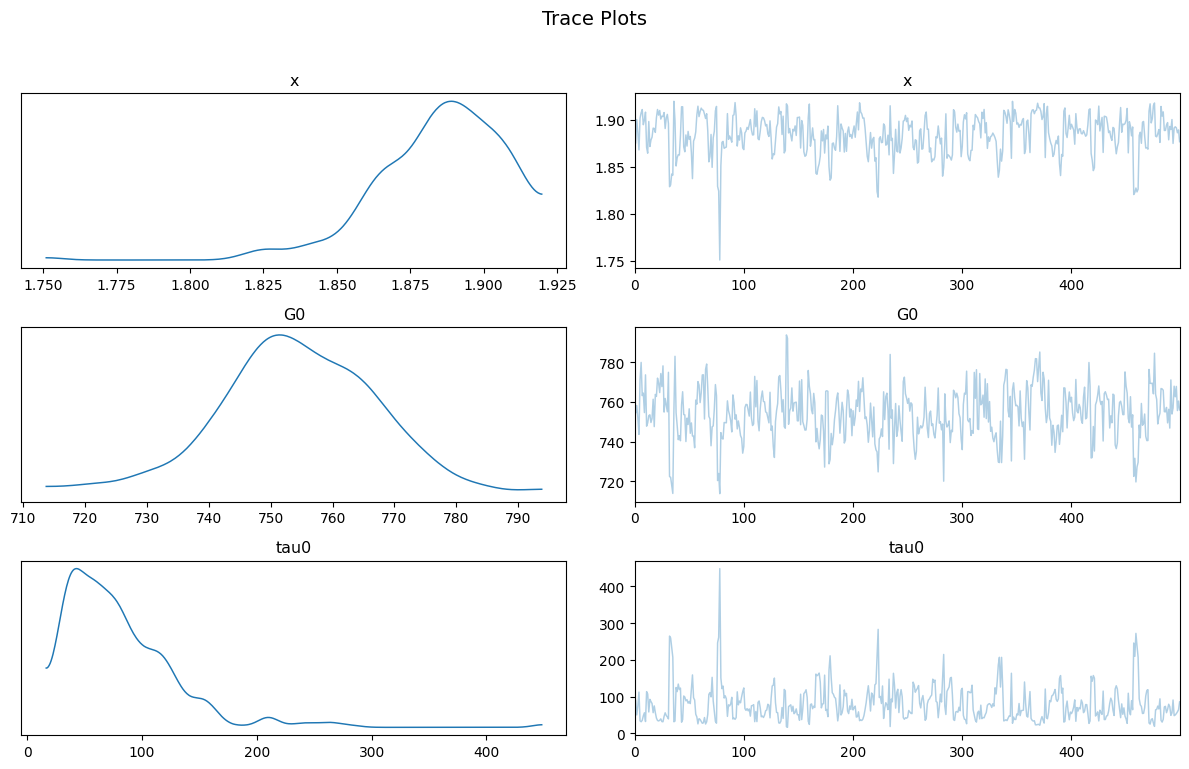

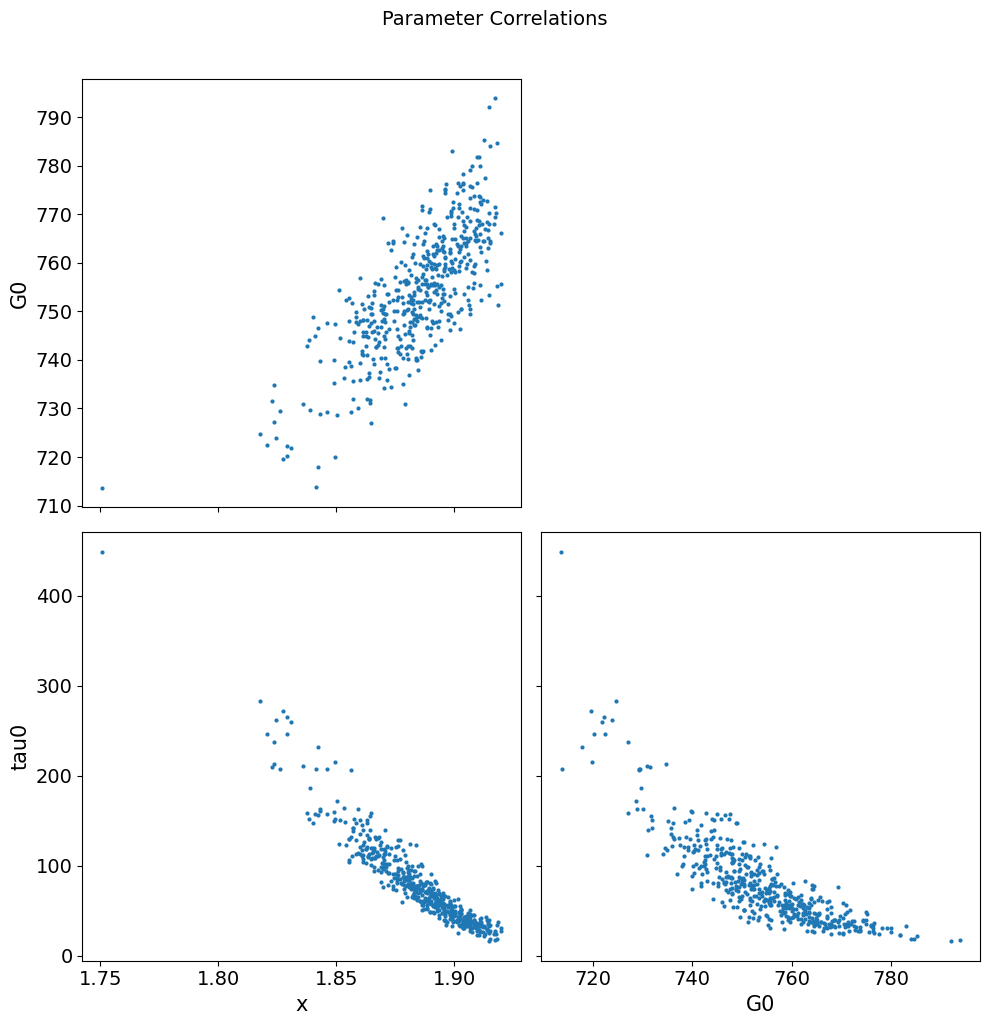

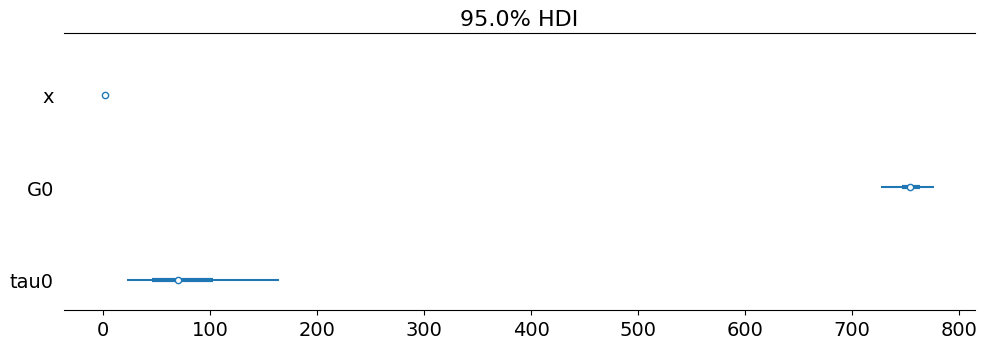

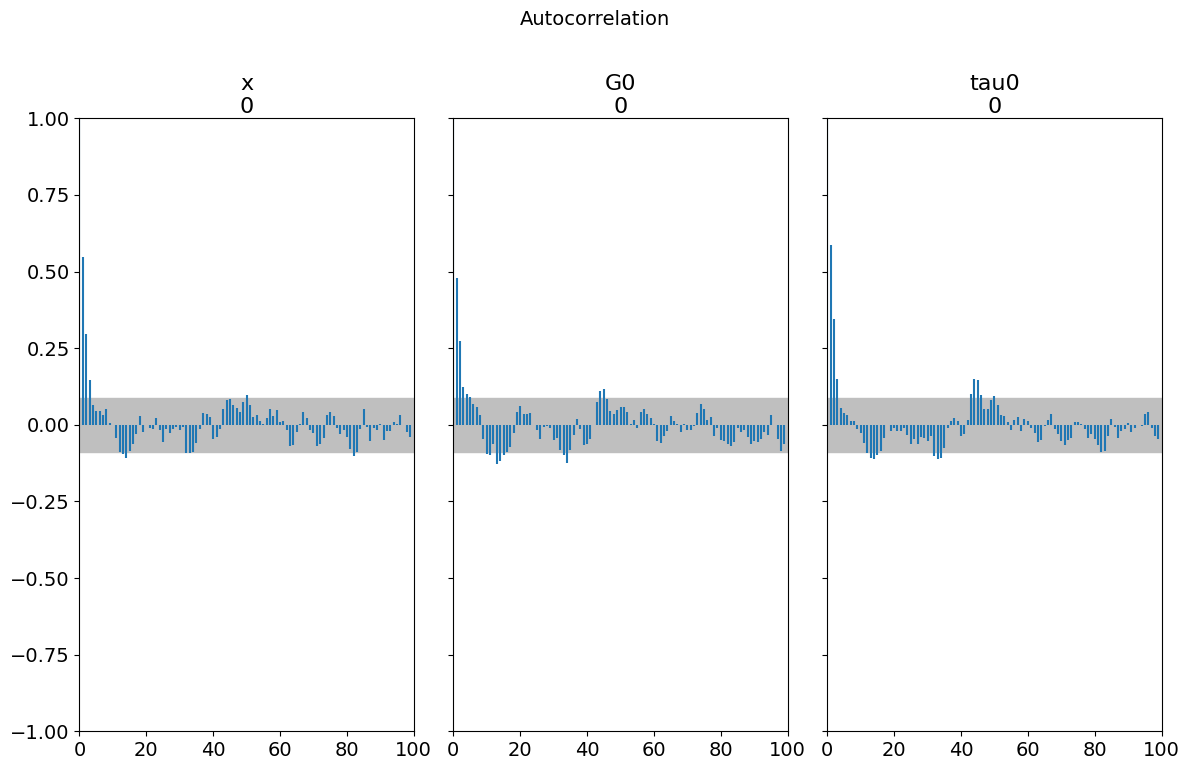

In [13]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorrelation, rank)
param_names = ["x", "G0", "tau0"]
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

### 5.4 Posterior Predictive Check

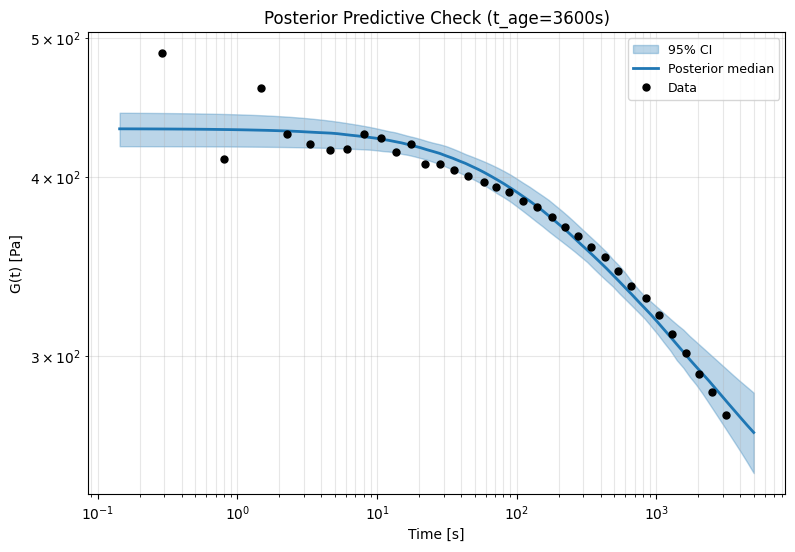

In [14]:
# Posterior predictive with 95% credible intervals
param_names = ["x", "G0", "tau0"]
fig, ax = plot_posterior_predictive(
    d["t"], d["G_t"], model, result,
    test_mode="relaxation", param_names=param_names,
    xlabel="Time [s]", ylabel="G(t) [Pa]",
    title="Posterior Predictive Check (t_age=3600s)",
)
display(fig)
plt.close(fig)

## 6. Save Results

In [15]:
output_dir = os.path.join("..", "outputs", "sgr", "relaxation")
os.makedirs(output_dir, exist_ok=True)

nlsq_params = {name: float(model.parameters.get_value(name)) for name in ["x", "G0", "tau0"]}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

aging_results = {str(k): v for k, v in fit_results.items()}
with open(os.path.join(output_dir, "aging_sweep_results.json"), "w") as f:
    json.dump(aging_results, f, indent=2)

# Save posterior samples (if available)
posterior = getattr(result, "posterior_samples", None) if "result" in dir() else None
if posterior is not None:
    posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
    with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
        json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")


Results saved to ../outputs/sgr/relaxation/


## Further Reading

- [SGR Conventional Handbook](../../docs/source/models/sgr/sgr_conventional.rst)
- [SGR Generic Handbook](../../docs/source/models/sgr/sgr_generic.rst)
- Sollich, P. (1998). Rheological constitutive equation for a model of soft glassy materials. *Phys. Rev. E*, 58, 738–759.
- Fielding, S.M. et al. (2000). Aging and rheology in soft materials. *J. Rheol.*, 44, 323–369.

## Next Steps

- **NB 03**: SAOS — frequency-domain view of the same power-law dynamics ($G' \sim G'' \sim \omega^{x-1}$)
- **NB 04**: Creep — complementary time-domain protocol ($J(t) \sim t^{x-1}$)
- **NB 01**: Flow curves — steady-state viscosity $\eta \sim \dot{\gamma}^{x-2}$
- **NB 06**: LAOS — nonlinear yielding in oscillatory shear